In [1]:
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestRegressor

# Load clean data
df = pd.read_csv(
    "../data/ml_ready_dataset_clean.csv",
    parse_dates=["from_date"]
)

df = df.sort_values("from_date").reset_index(drop=True)

TARGET = "PM2.5"
DROP_COLS = ["from_date", "station_id"]

X = df.drop(columns=DROP_COLS + [TARGET])
y = df[TARGET]

# Time split
split_idx = int(0.8 * len(df))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Train model
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Save model
joblib.dump(model, "../models/pm25_rf_model.pkl")

print("✅ Future prediction model trained & saved")


✅ Future prediction model trained & saved


In [2]:
# Take the most recent available row
latest_row = df.iloc[-1:].copy()

X_latest = latest_row.drop(columns=DROP_COLS + [TARGET])

future_pm25 = model.predict(X_latest)[0]

print("🔮 Predicted PM2.5 (next hour):", round(future_pm25, 2))


🔮 Predicted PM2.5 (next hour): 29.57


c:\Users\SAKSHI  A S\pose-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


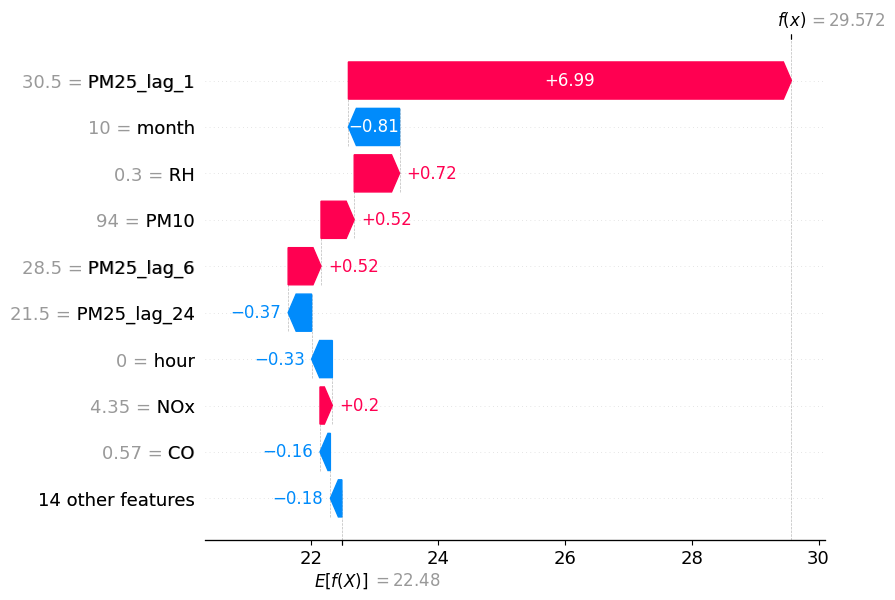

In [3]:
import shap

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_latest)

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value,
        data=X_latest.iloc[0],
        feature_names=X_latest.columns
    )
)


In [4]:
shap_df = pd.DataFrame({
    "feature": X_latest.columns,
    "shap_value": shap_values[0]
}).sort_values(by="shap_value", ascending=False)

top_reasons = shap_df.head(5)

top_reasons


,feature,shap_value
20,PM25_lag_1,6.989198
3,RH,0.715835
4,PM10,0.523610
21,PM25_lag_6,0.518563
7,NOx,0.195212


In [5]:
for _, row in top_reasons.iterrows():
    if row["shap_value"] > 0:
        print(f"{row['feature']} increased PM2.5")
    else:
        print(f"{row['feature']} decreased PM2.5")


PM25_lag_1 increased PM2.5
RH increased PM2.5
PM10 increased PM2.5
PM25_lag_6 increased PM2.5
NOx increased PM2.5


In [6]:
def calculate_aqi_pm25(pm25):
    breakpoints = [
        (0, 30, 0, 50),
        (31, 60, 51, 100),
        (61, 90, 101, 200),
        (91, 120, 201, 300),
        (121, 250, 301, 400),
        (251, 500, 401, 500)
    ]
    
    for c_low, c_high, aqi_low, aqi_high in breakpoints:
        if c_low <= pm25 <= c_high:
            return round(
                ((aqi_high - aqi_low) / (c_high - c_low)) *
                (pm25 - c_low) + aqi_low
            )
    return None


In [7]:
def aqi_category(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Satisfactory"
    elif aqi <= 200:
        return "Moderate"
    elif aqi <= 300:
        return "Poor"
    elif aqi <= 400:
        return "Very Poor"
    else:
        return "Severe"


In [8]:
aqi_value = calculate_aqi_pm25(future_pm25)
aqi_label = aqi_category(aqi_value)

print("🌫 AQI:", aqi_value)
print("📌 AQI Category:", aqi_label)


🌫 AQI: 49
📌 AQI Category: Good
